In [8]:
import numpy as np
import enviroment_no_visual as enviroment
import enviroment as enviroment_visual
import tensorflow as tf
import keras

In [9]:
input_shape = [11]
n_outputs = 3
model = keras.models.Sequential([
    keras.layers.Dense(256, activation='relu', input_shape = input_shape),
    keras.layers.Dense(n_outputs)
])

In [10]:
class ReplayBuffer:
    def __init__(self, max_size):
        self.buffer = np.empty(max_size, dtype=object)
        self.max_size = max_size
        self.index = 0
        self.size = 0

    def append(self, obj):
        self.buffer[self.index] = obj
        self.size = min(self.size + 1, self.max_size)
        self.index = (self.index + 1) % self.max_size

    def sample(self, batch_size):
        indices = np.random.randint(self.size, size=batch_size)
        return self.buffer[indices]
    

replay_buffer = ReplayBuffer(max_size=100_000)

def sample_experiences(batch_size):
    batch = replay_buffer.sample(batch_size)
    states, actions, rewards, next_states, game_over = [
        np.array([experience[field_index] for experience in batch])
                    for field_index in range(5)]
    return states, actions, rewards, next_states, game_over

In [11]:
def epsilon_greedy_policy(state, epsilon=0):
    if np.random.rand() < epsilon:
        return np.random.randint(n_outputs)
    else:
        Q_values = model.predict(state[np.newaxis], verbose=0)
        return np.argmax(Q_values[0])
    
def play_one_step(env, state, epsilon):
    action = epsilon_greedy_policy(state, epsilon)

    final_move = [0,0,0]
    final_move[action] = 1
    
    next_state, reward, game_over, score = env.play_step(final_move)
    replay_buffer.append((state, action, reward, next_state, game_over))
    return next_state, reward, game_over, score

In [12]:
BATCH_SIZE = 1000
discount_factor = 0.9
optimizer = keras.optimizers.Adam(learning_rate=1e-3)
loss_fn = keras.losses.mean_squared_error

def training_step(batch_size):
    # Campionamento delle esperienze
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, dones = experiences
    # Predizione dei valori Q per gli stati successivi
    next_Q_values = model.predict(next_states, verbose=0)
    max_next_Q_values = next_Q_values.max(axis=1)
    # Calcolo dei target utilizzando l'equazione di Bellman
    runs = 1.0 - dones 
    target_Q_values = rewards + runs * discount_factor * max_next_Q_values
    target_Q_values = target_Q_values.reshape(-1, 1)

    mask = tf.one_hot(actions, n_outputs)
    # Calcolo della loss
    with tf.GradientTape() as tape:
        all_Q_values = model(states)
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))
    # Calcolo dei gradienti e aggiornamento del modello
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

In [13]:
game_scores = [] 
best_score = 0
env = enviroment.SnakeGameAI()
MAX_N_GAMES = 100

epsilon = 1.0  
epsilon_decay = 0.98  

for episode in range(MAX_N_GAMES):
    env.reset()    
    state = env.get_state()
    restart = False
    step = 0
    while not restart:
        state, reward, done, score = play_one_step(env, state, epsilon)
        
        restart = done
        step += 1
    print(f"\rEpisode: {episode + 1}, Steps: {step + 1}, eps: {epsilon:.3f}, score: {score}. ", end="")

    if score >= best_score:
        best_weights = model.get_weights()
        best_score = score

    training_step(BATCH_SIZE)
    epsilon = max(0.05, epsilon * epsilon_decay)
    game_scores.append(score)

model.set_weights(best_weights) 

Episode: 1, Steps: 44, eps: 1.000, score: 0. 

Episode: 7, Steps: 52, eps: 0.886, score: 0. 

KeyboardInterrupt: 

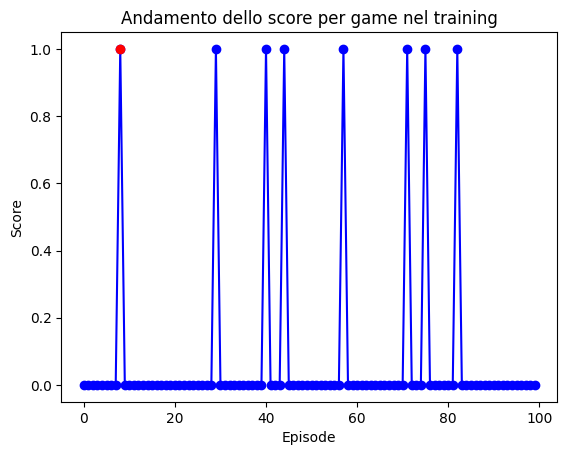

In [7]:
import matplotlib.pyplot as plt
indice_massimo = game_scores.index(max(game_scores))

# Creazione del grafico
plt.plot(game_scores, marker='o', linestyle='-', color='b')
plt.plot(indice_massimo, max(game_scores), marker='o', color='r')
plt.title('Andamento dello score per game nel training')
plt.xlabel('Episode')
plt.ylabel('Score')
plt.show()

Testa l'Agente seguendo la policy ottimale e mostra visualmente una sua partita

In [7]:
env = enviroment.SnakeGameAI()
MAX_N_GAMES = 100
cumulative_score = 0
max_score = 0

for n_game in range(MAX_N_GAMES):
    env.reset()
    game_over = False
    state= env.get_state()
    while not game_over:
        action = np.argmax(model.predict(state[np.newaxis], verbose=0)[0])
        final_move = [0,0,0]
        final_move[action] = 1
        state, reward, game_over, score = env.play_step(final_move)
    if score > max_score:
        max_score = score
    cumulative_score += score
    
print(f"Mean score: {cumulative_score/ MAX_N_GAMES}\nMax score: {max_score}", end="")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 

KeyboardInterrupt: 

In [20]:
env_visual = enviroment_visual.SnakeGameAI()
game_over = False
state = env_visual.get_state()
while not game_over:
    action = np.argmax(model.predict(state[np.newaxis], verbose=0)[0])

    final_move = [0,0,0]
    final_move[action] = 1

    state, reward, game_over, score = env_visual.play_step(final_move)